In [ ]:
!pip install torch
!pip install scipy 
!pip install torchmetrics
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
from sklearn import manifold
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
import scipy.io
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms

In [ ]:
import wandb
wandb.login(key="1262a78bcdb91721d1f31364cec1d26409dd981e")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ishit20380 (drake). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## PART 1

In [ ]:
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = scipy.io.loadmat("/content/gdrive/MyDrive/cv1.mat")

data_size = len(data['y'])
# data_size = 20000
data['y'][ data['y'] == 10 ] = 0


transform = transforms.Compose(
    
    [   
        transforms.ToTensor(),
        # transforms.Resize((32,32)),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

     ])

import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, data ,transform=None, target_transform=None):
        self.img_labels = data['y']
        self.img_dir = data['X']
        self.transform = transform
        self.data = data

        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = self.img_dir[:,:,:,idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
            # image = image.to(device)
        if self.target_transform:
            label = self.target_transform(label)
        # print(idx)
        return image, label


# shuffle
indices = list(range(data_size))
np.random.shuffle(indices)

test_size =  int(  0.10*data_size )
val_size =   int(  0.20*data_size )
train_size = int(  0.70*data_size )

test_index = indices[:test_size]
train_index = indices[test_size:test_size+train_size]
val_index = indices[-val_size:]

g = torch.Generator()
g.manual_seed(42)
batch_size = 64

train_sampler=SubsetRandomSampler(train_index, generator=g)
val_sampler=SubsetRandomSampler(val_index, generator=g)
test_sampler=SubsetRandomSampler(test_index, generator=g)

xt = data['X'][:train_size]
yt = data['y'][:train_size]
data_train = {'X':xt,'y':yt}

xt = data['X'][:test_size]
yt = data['y'][:test_size]
data_test = {'X':xt,'y':yt}

xt = data['X'][-val_size:]
yt = data['y'][-val_size:]
data_val = {'X':xt,'y':yt}

In [ ]:
# x = np.arange(1,10)
# p = np.array([1,2,3])
# x[p]

In [ ]:
# for i in range(test_size,-val_size+data_size):
#   if(data['X'][:,:,:,i].shape!=((32, 32, 3))):
#     print("yo!!")
#     break


In [ ]:
# train = CustomImageDataset(data_train,transform)
# test =  CustomImageDataset(data_test,transform)
# val =  CustomImageDataset(data_val,transform)

final_dataset = CustomImageDataset(data,transform)

trainloader = torch.utils.data.DataLoader(final_dataset, sampler = train_sampler, batch_size=batch_size,num_workers=2)
valloader = torch.utils.data.DataLoader(final_dataset, sampler = val_sampler, batch_size=batch_size,num_workers=2)
testloader = torch.utils.data.DataLoader(final_dataset, sampler = test_sampler, batch_size=batch_size,num_workers=2)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

In [ ]:
print(images.shape)

torch.Size([64, 3, 32, 32])


tensor([7], dtype=torch.uint8)


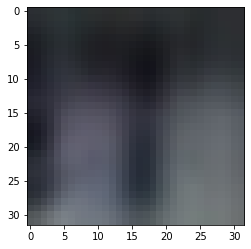

In [ ]:
idx = 8
plt.imshow(images[idx].permute(1,2,0))
print(labels[idx])

In [ ]:
y_train = []
y_val = []

for idx in train_index:
  # print(type(idx))
  if(data['y'][idx] == 0):
      y_train.append(10)
  else:
      y_train.append(data['y'][idx])

for idx in val_index:
    if(data['y'][idx] == 0):
        y_val.append(10)
    else:
        y_val.append(data['y'][idx])

print(len(y_train)) 
print(len(y_val))

51279
14651


<ipython-input-53-9ec1fc2a3a59>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train = np.array(y_train)
<ipython-input-53-9ec1fc2a3a59>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_val = np.array(y_val)


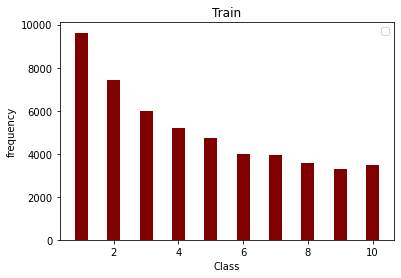

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)

# visualizing
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, color ='maroon',
        width = 0.4)
plt.title("Train")

plt.xlabel("Class")
plt.ylabel("frequency")
plt.legend()

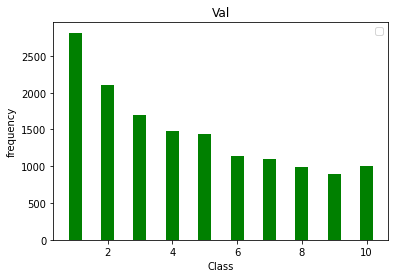

In [ ]:
unique, counts = np.unique(y_val, return_counts=True)
plt.bar(unique, counts, color ='green',
        width = 0.4)
plt.title("Val")

plt.xlabel("Class")
plt.ylabel("frequency")
plt.legend()

## Part 2

In [ ]:
# part (a)
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding=1)
        self.relu1 = ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.relu2 = ReLU()
        self.fc1 = nn.Linear(65536, 10)

        # self.relu3 = ReLU()
        # self.fc2 = nn.Linear(128, 10)
        # self.logSoftmax = LogSoftmax(dim=1)
      
    def forward(self,x):
        x = self.relu1((self.conv1(x)))
        x = self.relu2((self.conv2(x)))
        # x = relu2((self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        # x = self.relu3(self.fc1(x))
        x = self.fc1(x)
        # output = self.logSoftmax(x)
        return x



In [ ]:
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

model = CNN()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
criterion =  nn.CrossEntropyLoss()
# checking if GPU is available
model = model.to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=65536, out_features=10, bias=True)
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Q1",
)
## command to log gradients to wandb
wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis


total_loss_train = []
total_loss_validation = []


## command to log gradients to wandb
# wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis
epochs = 10
for epoch in range(epochs):  
    # print(epoch + 1)
    
    batch_loss_train=0
    batch_loss_val=0

    num_batches = 0
    correct = 0
    total = 0
    cnt=0
    for i, data in enumerate(trainloader, 0):
        


        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.reshape((len(labels),))
       
        total += labels.size(0)
        cnt+=1

        train_pred = torch.max(outputs, 1).indices
        correct += int(torch.sum(train_pred == labels))
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss_train+=loss.item()
        running_loss = loss.item()
        # print('[epoch, batch] =  [%d, %5d] loss: %.6f' %(epoch + 1, i, running_loss))
        num_batches+=1
        # print(num_batches)

    batch_loss_train/=num_batches
    acc = 100 * correct / total

    wandb.log(
          {"train accuracy" : acc,"train loss":batch_loss_train}
          )

    print("Trainging Accuracy ",acc)
    print("Trianing Loss ",batch_loss_train)

    total_loss_train.append(batch_loss_train)
    
    # Valdiation Loop
    with torch.no_grad():
      correct = 0
      total = 0
      cnt=0
      # ✨ W&B: parameters
      log_counter = 0
      NUM_BATCHES_TO_LOG = 10
      NUM_IMAGES_PER_BATCH = 64
      i=-1
      for data in valloader:
          i+=1
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Get Prediction
          outputs = model(inputs)

          # Compute loss 
          total += labels.size(0)
          cnt+=1
          #labels = labels.float()
          labels = labels.reshape((len(labels),))
          
          #print(outputs.shape)
          loss_val = criterion(outputs, labels)
          batch_loss_val += loss_val.item()
          

          out_cpu = outputs.cpu()
          predicted = [np.argmax(x) for x in out_cpu]
          predicted = torch.Tensor(predicted).to(device)
          correct += (predicted == labels).sum().item()

  
      acc = 100 * correct / total
      total_loss_validation += [batch_loss_val/cnt]
      #W&B: Log accuracy across training epochs, to visualize in the UI
     

      print("Validation loss is ",batch_loss_val/cnt)
      print("Validation Acc is ", acc)

      wandb.log(
          {"val accuracy" :acc ,"val loss":batch_loss_val/cnt}
          )

print('Finished Training')

Trainging Accuracy  44.68885898710973
Trianing Loss  1.661302262410856
Validation loss is  1.0196425834076894
Validation Acc is  68.99187768752986
Trainging Accuracy  76.9398779227364
Trianing Loss  0.775113595579925
Validation loss is  0.6584371346573642
Validation Acc is  81.15486997474575
Trainging Accuracy  83.49811813802921
Trianing Loss  0.5744765225119721
Validation loss is  0.5841329142646497
Validation Acc is  83.5233089891475
Trainging Accuracy  85.5886425242302
Trianing Loss  0.5014002423482643
Validation loss is  0.5615474331847445
Validation Acc is  84.40379496280117
Trainging Accuracy  87.00052653132862
Trianing Loss  0.4546729487336782
Validation loss is  0.5659140012019587
Validation Acc is  84.45157327144905
Trainging Accuracy  87.73767039138829
Trianing Loss  0.42323093084697416
Validation loss is  0.5685454843216068
Validation Acc is  84.3218892908334
Trainging Accuracy  88.45726320716082
Trianing Loss  0.3977654669015782
Validation loss is  0.5598507972523635
Valida

In [ ]:
true = torch.tensor([]).to(device)
pred = torch.tensor([]).to(device)

# test_accuracy = 0


# with torch.no_grad():
#         for image,label in testloader:
#             image = image.to(device)
#             test_prob = model(image)
#             test_prob = test_prob.cpu()
#             label = torch.reshape(label, (-1,)).long()
#             test_pred = torch.max(test_prob,1).indices
#             test_accuracy += int(torch.sum(test_pred == label))
#             label = torch.reshape(label, (-1,)).long()


#             loss = criterion(test_prob, label)

#             count = 0
#             for i in range(len(test_pred)):
#               if(count == 3):
#                 break
#               if(test_pred[i]!=label[i]):
#                   f1_pred = torch.cat((misclassified_img,image))
#                   misclassified_label = torch.cat((misclassified_label, train_pred))
#                   count+=1

#             f1_true = torch.cat((f1_true, label.to(device)))
#             f1_pred = torch.cat((f1_pred, test_prob.to(device)))
            
#         test_accuracy_epoch = test_accuracy / test_size

# wandb. log({"conf_mat" : wandb. plot. confusion_matrix(probs=None,
# y_true=f1_true, preds=f1_pred,
# class_names=[0,1,2,3,4,5,6,7,8,9,10])})
       
# print(len(f1_pred))        

from torchmetrics.classification import F1Score
# print(f1_true)
# print(f1_pred)


true_val = torch.tensor([]).to(device)
pred_val = torch.tensor([]).to(device)
ll = 0

with torch.no_grad():
      correct = 0
      total = 0
      cnt=0
      # ✨ W&B: parameters
      log_counter = 0
      NUM_BATCHES_TO_LOG = 10
      NUM_IMAGES_PER_BATCH = 64
      i=-1
      for data in testloader:
          i+=1
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Get Prediction
          outputs = model(inputs)

          # Compute loss 
          total += labels.size(0)
          cnt+=1
          #labels = labels.float()
          labels = labels.reshape((len(labels),))
          
          #print(outputs.shape)
          loss_val = criterion(outputs, labels)
          batch_loss_val += loss_val.item()
          

          out_cpu = outputs.cpu()
          predicted = [np.argmax(x) for x in out_cpu]
          predicted = torch.Tensor(predicted).to(device)
          correct += (predicted == labels).sum().item()

          true_val = torch.cat((true_val, labels))
          pred_val = torch.cat((pred_val, predicted))

          ll+=len(labels)
  
      acc = 100 * correct / total
      total_loss_validation += [batch_loss_val/cnt]

      
      # ✨ W&B: Log accuracy across training epochs, to visualize in the UI
     


f1 = F1Score(task="multiclass", num_classes=10)
print(f1(pred_val.cpu(), true_val.cpu()))
# print(test_accuracy_epoch*100)
print(acc)      
print('Finished Testing...')

tensor(0.8426)
84.25938566552901
Finished Testing...


In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix
metric = MulticlassConfusionMatrix(num_classes=10)
metric(pred_val.cpu(), true_val.cpu())

tensor([[ 389,   16,   13,    2,    1,    2,   16,    6,    4,   17],
        [  20, 1285,   18,   19,   23,    8,    8,   19,   12,    8],
        [   7,   15,  953,   13,    3,    6,    1,   15,    9,   12],
        [   5,   21,   31,  612,    6,   57,   25,   19,   23,   26],
        [   7,   45,   19,   15,  628,    4,    8,    3,   11,    8],
        [   1,    8,    8,   43,    3,  597,   38,    4,   10,   11],
        [  12,   17,    7,   13,    7,   31,  463,    3,   22,    7],
        [   3,   26,   23,   13,    5,    2,    3,  496,    1,    6],
        [   7,   18,   10,   21,    3,    7,   20,    5,  386,   13],
        [  12,   11,   21,   13,    5,   12,    6,    2,   14,  363]])

In [ ]:
filename = '/content/gdrive/MyDrive/Datasets/cnn.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
all_labels = [0,1,2,3,4,5,6,7,8,9]
# preds = pred_val.cpu().numpy().astype(int)
# y_true = true_val.cpu().numpy().astype(int)
preds = []
y_true = []
for i in pred_val.cpu():
    preds.append((int(i.item())))
for i in true_val.cpu():
    y_true.append((int(i.item())))

wandb.log({"my_conf_mat_id" : wandb.plot.confusion_matrix( 
            preds=preds, y_true=y_true,
            class_names=all_labels)})

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="Q1",
# )
# ## command to log gradients to wandb
# wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis


# # LEN_TRAIN = train_size
# for epoch in range(5):
    
#     train_accuracy = 0
#     test_accuracy = 0
    
#     # Train
#     model.train()
#     f1_true = torch.tensor([])
#     f1_pred = torch.tensor([])

#     #
#     misclassified_img = torch.tensor([])
#     misclassified_label = torch.tensor([])
    
#     with tqdm(trainloader, unit="batch") as tepoch:
#         for image,label in tepoch:
#             optimiser.zero_grad()
            
#             image = image.to(device)
#             train_prob = model(image)
#             train_prob = train_prob.cpu()
            
#             label = torch.reshape(label, (-1,)).long()
#             loss = loss_fn(train_prob, label)
#             loss.backward()
#             optimiser.step()
            
#             train_pred = torch.max(train_prob, 1).indices
#             train_accuracy += int(torch.sum(train_pred == label))

#             f1_true = torch.cat((f1_true, label))
#             f1_pred = torch.cat((f1_pred, train_pred))
            
#             # count = 0
#             # for i in range(len(train_pred)):
#             #   if(count == 3):
#             #     break
#             #   if(train_pred[i]!=label[i]):
#             #       misclassified_img = torch.cat((misclassified_img,image))
#             #       misclassified_label = torch.cat((misclassified_label, train_pred))
#             #       count+=1
#         tr_loss = loss    
#         print(train_accuracy)
#         train_accuracy_epoch = (train_accuracy / train_size)

#         wandb.log(
#           {"train accuracy" : train_accuracy_epoch,"train loss":loss}
#           )
    
#     # validation_loss, accuracy = validation(model, testloader, criterion)
#     # Evaluate
#     model.eval()
#     # with torch.no_grad():
#     #       validation_loss, accuracy = validation(model, trainloader, criterion)


#     with torch.no_grad():
#         for image,label in valloader:
#             image = image.to(device)
#             test_prob = model(image)
#             test_prob = test_prob.cpu()
#             label = torch.reshape(label, (-1,)).long()
#             test_pred = torch.max(test_prob,1).indices
#             test_accuracy += int(torch.sum(test_pred == label))
#             label = torch.reshape(label, (-1,)).long()
#             loss = loss_fn(test_prob, label)            
#             count = 0
#             for i in range(len(test_pred)):
#               if(count == 3):
#                 break
#               if(test_pred[i]!=label[i]):
#                   misclassified_img = torch.cat((misclassified_img,image))
#                   misclassified_label = torch.cat((misclassified_label, train_pred))
#                   count+=1


            
#         test_accuracy_epoch = test_accuracy / val_size

#         wandb.log(
#           {"val accuracy" : test_accuracy_epoch,"val loss":loss}
#           )
#     # test_accuracy_epoch = 0
    
#     print(f"Epoch: {epoch+1}  , Loss: {tr_loss} , Train_acc: {train_accuracy_epoch}, Val_acc: {test_accuracy_epoch} , Val Loss:{loss}")


# # artifact = wandb.Artifact('model', type='model')
# # artifact.add_file('model.pth')
# # wandb.log_artifact(artifact)

In [ ]:
# len(misclassified_img)

# idx = -7
# misclassified_img[idx]

# plt.imshow(misclassified_img[idx].permute(1,2,0))
# print(labels[idx])

In [ ]:
# idx = -16
# misclassified_img[idx]

# plt.imshow(misclassified_img[idx].permute(1,2,0))
# print(labels[idx])

In [ ]:
# from torchmetrics.classification import F1Score
# # print(f1_true)
# # print(f1_pred)
# f1 = F1Score(task="multiclass", num_classes=10)
# f1(f1_pred, f1_true)

In [ ]:
# f1_true = torch.tensor([])
# f1_pred = torch.tensor([])

# with torch.no_grad():
#         for image,label in valloader:
#             image = image.to(device)
#             test_prob = model(image)
#             test_prob = test_prob.cpu()
#             label = torch.reshape(label, (-1,)).long()
#             test_pred = torch.max(test_prob,1).indices
#             test_accuracy += int(torch.sum(test_pred == label))
#             label = torch.reshape(label, (-1,)).long()
#             # loss = loss_fn(test_prob, label)

#             count = 0
#             for i in range(len(test_pred)):
#               if(count == 3):
#                 break
#               if(test_pred[i]!=label[i]):
#                   misclassified_img = torch.cat((misclassified_img,image))
#                   misclassified_label = torch.cat((misclassified_label, train_pred))
#                   count+=1

#             f1_true = torch.cat((f1_true, label))
#             f1_pred = torch.cat((f1_pred, test_prob))
            
#         test_accuracy_epoch = test_accuracy / test_size

#         wandb.log(
#           {"test accuracy" : test_accuracy_epoch,"test loss":loss}
#           )
        

# from torchmetrics.classification import F1Score
# # print(f1_true)
# # print(f1_pred)
# f1 = F1Score(task="multiclass", num_classes=10)
# print(f1(f1_pred, f1_true))
# print(test_accuracy_epoch)


## Trash

In [ ]:
#   for epoch in range(1):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs.float()
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(inputs)
#         labels = torch.reshape(labels, (-1,)).long()
#         # print(labels)
#         loss = criterion(outputs, labels)
#         print(loss)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         print(running_loss)

#         # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#         if i % 10 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0

# print('Finished Training')

In [ ]:
# # data_size = len(data['X'])
# data_size = 2000

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# # shuffle
# indices = list(range(data_size))
# np.random.shuffle(indices)

# test_size =  int(  0.10*data_size )
# val_size =   int(  0.20*data_size )
# train_size = int(  0.70*data_size )


# test_index =  indices[:test_size]
# train_index = indices[test_size:test_size+train_size]
# val_index = indices[-val_size:]

# # df_test = torch.tensor(torch.tensor(data['X'][test_index]),torch.tensor(data['y'][test_index]))

# # from torch.utils.data import TensorDataset
# # label = torch.tensor(data['y'],)
# # img_arr = torch.tensor(data['X'])
# # df = TensorDataset(img_arr, label)


# gen = torch.Generator()
# gen.manual_seed(42)

# train_sampler=SubsetRandomSampler(train_index, generator=gen)
# val_sampler=SubsetRandomSampler(val_index, generator=gen)
# test_sampler=SubsetRandomSampler(test_index, generator=gen)

# batch_size = 64
# trainloader = torch.utils.data.DataLoader(df, sampler = train_sampler, batch_size=batch_size,num_workers=2)
# # valloader = torch.utils.data.DataLoader(df, sampler = val_sampler, batch_size=batch_size,num_workers=2)
# # testloader = torch.utils.data.DataLoader(df,sampler = test_sampler, batch_size=batch_size,num_workers=2)

In [ ]:
# training
y_train = data['y'][train_index]
y_val = data['y'][val_index]

<BarContainer object of 10 artists>

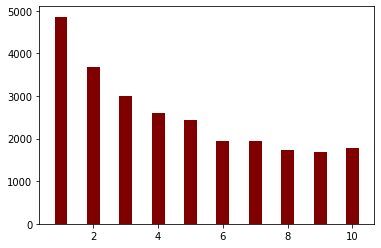

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, color ='maroon',
        width = 0.4)

<BarContainer object of 10 artists>

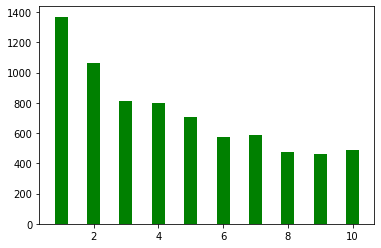

In [ ]:
unique, counts = np.unique(y_val, return_counts=True)
plt.bar(unique, counts, color ='green',
        width = 0.4)

## RESNET

In [ ]:
# https://github.com/shounak8/AIML_Tutotials/blob/master/Deep_Learning/PyTorch/santa_or_not/santa_pytorch_pretrained_model.ipynb

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [ ]:
model = resnet18(pretrained=True) # using pre trained resnet
model.fc = Linear(in_features=512, out_features=10)  # changing the dimensions of last output layer to number of classes
model = model.to(device) # using gpu

optimizer = Adam(model.parameters(), lr=0.01) # choosing optimizer and setting cross entropy loss
loss_function = CrossEntropyLoss()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model = resnet18(pretrained=True)   #load resnet18 model
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 10) #(num_of_class == 2)
model = model.to(device) 
loss_fn = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Q1",
)
## command to log gradients to wandb
wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis


total_loss_train = []
total_loss_validation = []


## command to log gradients to wandb
# wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis
epochs = 10
for epoch in range(epochs):  
    # print(epoch + 1)
    
    batch_loss_train=0
    batch_loss_val=0

    num_batches = 0
    correct = 0
    total = 0
    cnt=0
    for i, data in enumerate(trainloader, 0):
        


        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.reshape((len(labels),))
       
        total += labels.size(0)
        cnt+=1

        train_pred = torch.max(outputs, 1).indices
        correct += int(torch.sum(train_pred == labels))
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss_train+=loss.item()
        running_loss = loss.item()
        # print('[epoch, batch] =  [%d, %5d] loss: %.6f' %(epoch + 1, i, running_loss))
        num_batches+=1
        # print(num_batches)

    batch_loss_train/=num_batches
    acc = 100 * correct / total

    wandb.log(
          {"train accuracy" : acc,"train loss":batch_loss_train}
          )

    print("Trainging Accuracy ",acc)
    print("Trianing Loss ",batch_loss_train)

    total_loss_train.append(batch_loss_train)
    
    # Valdiation Loop
    with torch.no_grad():
      correct = 0
      total = 0
      cnt=0
      # ✨ W&B: parameters
      log_counter = 0
      NUM_BATCHES_TO_LOG = 10
      NUM_IMAGES_PER_BATCH = 64
      i=-1
      for data in valloader:
          i+=1
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Get Prediction
          outputs = model(inputs)

          # Compute loss 
          total += labels.size(0)
          cnt+=1
          #labels = labels.float()
          labels = labels.reshape((len(labels),))
          
          #print(outputs.shape)
          loss_val = criterion(outputs, labels)
          batch_loss_val += loss_val.item()
          

          out_cpu = outputs.cpu()
          predicted = [np.argmax(x) for x in out_cpu]
          predicted = torch.Tensor(predicted).to(device)
          correct += (predicted == labels).sum().item()

  
      acc = 100 * correct / total
      total_loss_validation += [batch_loss_val/cnt]
      # ✨ W&B: Log accuracy across training epochs, to visualize in the UI
     

      print("Validation loss is ",batch_loss_val/cnt)
      print("Validation Acc is ", acc)

      wandb.log(
          {"val accuracy" :acc ,"val loss":batch_loss_val/cnt}
          )

print('Finished Training')

train accuracy,▁▆▇▇▇█████
train loss,█▃▂▂▂▂▁▁▁▁
val accuracy,▁▆▇███████
val loss,█▃▁▁▁▁▁▁▂▂
train accuracy,90.58289
train loss,0.31948
val accuracy,83.75538
val loss,0.63208


Trainging Accuracy  70.44404142046452
Trianing Loss  0.8906174714205568
Validation loss is  0.4853588039437756
Validation Acc is  84.75871954132823
Trainging Accuracy  87.95023303886582
Trianing Loss  0.38317989869196517
Validation loss is  0.38562082974280854
Validation Acc is  88.28748890860692
Trainging Accuracy  91.33173423818717
Trianing Loss  0.28353108303096525
Validation loss is  0.3621531414705853
Validation Acc is  89.22257866357245
Trainging Accuracy  93.06733750658164
Trianing Loss  0.2250010398125968
Validation loss is  0.3531844632529275
Validation Acc is  89.79591836734694
Trainging Accuracy  94.2491078219154
Trianing Loss  0.18518371405799935
Validation loss is  0.34705339102115174
Validation Acc is  90.33513070780151
Trainging Accuracy  95.15201154468691
Trianing Loss  0.15530002036333976
Validation loss is  0.36138066210210584
Validation Acc is  90.06893727390622
Trainging Accuracy  95.97691062618226
Trianing Loss  0.12555217097148746
Validation loss is  0.34940747036

In [ ]:
# testing
true = torch.tensor([]).to(device)
pred = torch.tensor([]).to(device)


from torchmetrics.classification import F1Score
# print(f1_true)
# print(f1_pred)


true_val = torch.tensor([]).to(device)
pred_val = torch.tensor([]).to(device)
ll = 0

with torch.no_grad():
      correct = 0
      total = 0
      cnt=0
      # ✨ W&B: parameters
      log_counter = 0
      NUM_BATCHES_TO_LOG = 10
      NUM_IMAGES_PER_BATCH = 64
      i=-1
      for data in testloader:
          i+=1
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Get Prediction
          outputs = model(inputs)

          # Compute loss 
          total += labels.size(0)
          cnt+=1
          #labels = labels.float()
          labels = labels.reshape((len(labels),))
          
          #print(outputs.shape)
          loss_val = criterion(outputs, labels)
          batch_loss_val += loss_val.item()
          

          out_cpu = outputs.cpu()
          predicted = [np.argmax(x) for x in out_cpu]
          predicted = torch.Tensor(predicted).to(device)
          correct += (predicted == labels).sum().item()

          true_val = torch.cat((true_val, labels))
          pred_val = torch.cat((pred_val, predicted))

          ll+=len(labels)
  
      acc = 100 * correct / total
      total_loss_validation += [batch_loss_val/cnt]

      
      # ✨ W&B: Log accuracy across training epochs, to visualize in the UI
     


f1 = F1Score(task="multiclass", num_classes=10)
print(f1(pred_val.cpu(), true_val.cpu()))
# print(test_accuracy_epoch*100)
print(acc)      
print('Finished Testing...')

tensor(0.9025)
90.25255972696246
Finished Testing...


In [ ]:
all_labels = [0,1,2,3,4,5,6,7,8,9]
# preds = pred_val.cpu().numpy().astype(int)
# y_true = true_val.cpu().numpy().astype(int)
preds = []
y_true = []
for i in pred_val.cpu():
    preds.append((int(i.item())))
for i in true_val.cpu():
    y_true.append((int(i.item())))

wandb.log({"my_conf_mat_id" : wandb.plot.confusion_matrix( 
            preds=preds, y_true=y_true,
            class_names=all_labels)})

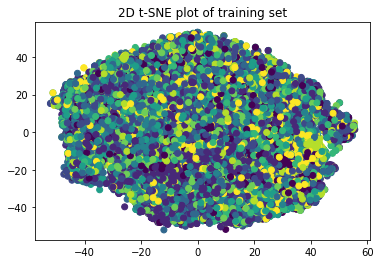

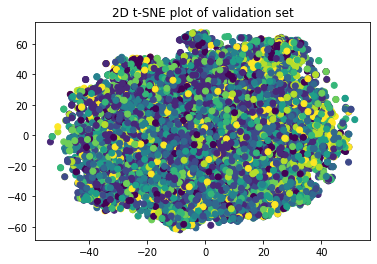

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore")

# For input
# samples from the training and validation sets, extract the feature vectors using
# the backbone (ResNet-18 in this case) and visualize them in the feature space
# using the tSNE plot in a 2-D Space. Also, visualize the tSNE plot of the
# validation set in a 3D-Space.

# Load pre-trained ResNet-18 model and freeze weights
resnet = resnet18(pretrained=True)
# for param in resnet.parameters():
#     param.requires_grad = False

# Extract feature vectors for training and validation sets
train_features = []
train_labels = []
for images, labels in trainloader:
    with torch.no_grad():
        features = resnet(images)
    train_features.append(features.cpu().numpy())
    train_labels.append(labels.numpy())

train_features = np.concatenate(train_features)
train_labels = np.concatenate(train_labels)

val_features = []
val_labels = []
for images, labels in valloader:
    with torch.no_grad():
        features = resnet(images)
    val_features.append(features.cpu().numpy())
    val_labels.append(labels.numpy())

val_features = np.concatenate(val_features)
val_labels = np.concatenate(val_labels)

# Reduce dimensionality of feature vectors using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
train_tsne = tsne.fit_transform(train_features)
val_tsne = tsne.fit_transform(val_features)

# Visualize 2D t-SNE plot of training set
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_labels)
plt.title('2D t-SNE plot of training set')
plt.show()

# Visualize 2D t-SNE plot of validation set
plt.scatter(val_tsne[:, 0], val_tsne[:, 1], c=val_labels)
plt.title('2D t-SNE plot of validation set')
plt.show()

# Reduce dimensionality of feature vectors using t-SNE for 3D plot
# tsne_3d = TSNE(n_components=3, perplexity=30, random_state=0)
# val_tsne_3d = tsne_3d.fit_transform(val_features)

# # Visualize 3D t-SNE plot of validation set
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax

In [ ]:
# from torchmetrics.classification import F1Score
# # print(f1_true)
# print(f1_pred)
# f1 = F1Score(task="multiclass", num_classes=10)
# f1(f1_pred, f1_true)

tensor(0.0905)

In [ ]:
labels = None
features = None
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        features = model.get_features(images)
      
print(features)

tensor([[ 1.0732, -0.1563, -0.9011,  ..., -3.4389, -1.0389, -0.7465],
        [-0.6167, -0.8459, -0.2426,  ...,  0.2298,  0.2022,  0.2082],
        [ 1.5768,  0.8436,  0.0436,  ..., -0.2039, -0.0534,  0.1282],
        ...,
        [-0.1947, -1.3528, -1.0856,  ...,  0.9888, -0.0083, -1.0834],
        [ 1.5978,  0.2717,  0.2054,  ..., -1.5825, -1.1811,  0.9422],
        [ 1.9095,  0.2840, -0.2494,  ...,  0.7040, -1.0199, -2.8788]])


In [ ]:
# LEN_TRAIN = 2000
# for epoch in range(2):
    
    
#     tr_acc = 0
#     test_acc = 0
    
#     # Train
#     model.train()
    

#     f1_true = torch.tensor([])
#     f1_pred = torch.tensor([])

  
    
#     with tqdm(trainloader, unit="batch") as tepoch:
#         for xtrain, ytrain in tepoch:
#             optimiser.zero_grad()
            
#             xtrain = xtrain.to(device)
#             train_prob = model(xtrain)
#             train_prob = train_prob.cpu()
            


#             ytrain = torch.reshape(ytrain, (-1,)).long()

            

#             loss = loss_fn(train_prob, ytrain)
#             loss.backward()
#             optimiser.step()
            
#             # training ends
            
#             train_pred = torch.max(train_prob, 1).indices

#             f1_true = torch.cat((f1_true, ytrain))
#             f1_pred = torch.cat((f1_pred, train_pred))

#             tr_acc += int(torch.sum(train_pred == ytrain))
            
#         ep_tr_acc = tr_acc / LEN_TRAIN
    
#     # Evaluate
#     # model.eval()
#     # with torch.no_grad():
#     #     for xtest, ytest in test_loader:
#     #         xtest = xtest.to(device)
#     #         test_prob = model(xtest)
#     #         test_prob = test_prob.cpu()
            
#     #         test_pred = torch.max(test_prob,1).indices
#     #         test_acc += int(torch.sum(test_pred == ytest))
            
#     #     ep_test_acc = test_acc / LEN_TEST
    
   
    
#     print(f"Epoch: {epoch}, Time: {0}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Test_acc: {0}")

100%|██████████| 32/32 [00:17<00:00,  1.83batch/s]


Epoch: 0, Time: 0, Loss: 2.636685371398926
Train_acc: 0.0905, Test_acc: 0


100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]

Epoch: 1, Time: 0, Loss: 2.636685371398926
Train_acc: 0.0905, Test_acc: 0


In [ ]:
# ytrain = torch.reshape(ytrain, (-1,)).long()
# ytrain

tensor([8, 4, 1, 2, 9, 5, 6, 2, 9, 1, 1, 5, 2, 1, 3, 3])

In [ ]:
# torch.max(train_prob, 1)

torch.return_types.max(
values=tensor([0.9538, 0.7797, 1.3748, 1.5034, 1.3536, 0.7009, 1.2162, 1.0941, 1.3805,
        1.3677, 2.2909, 1.6346, 1.1408, 1.1597, 1.2788, 0.7480],
       grad_fn=<MaxBackward0>),
indices=tensor([0, 2, 5, 3, 2, 5, 4, 4, 2, 6, 6, 5, 6, 6, 6, 2]))

In [ ]:
a = torch.randn(1, 3)
a

tensor([[ 0.5987, -0.4885,  1.4049]])

In [ ]:
torch.max(a,1).indices

tensor([2])

In [ ]:
b = torch.randn(1, 3)
b

tensor([[-0.3623,  0.6409, -0.4022]])

In [ ]:
a = torch.cat((a, b))

In [ ]:
b1 = torch.tensor([12,3])
b1

tensor([12,  3])

In [ ]:
a1 = torch.tensor([2,3])
a1

tensor([2, 3])

In [ ]:
f1_true = torch.tensor([])
f1_true = torch.cat((f1_true, labels))


In [ ]:
for i in range(len(a1)):
  print(a1[i] == 2)

tensor(True)
tensor(False)


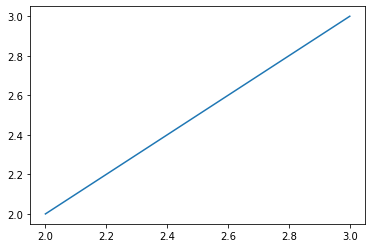

In [ ]:
plt.plot(a1.numpy(),[2,3])

## Part 4

In [ ]:
# Augument the training data
transform = transforms.Compose(
    
    [   
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomGrayscale(p=0.3),
        transforms.RandomRotation(degrees = 45),
        transforms.ColorJitter(brightness=0.75)
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
     ])

aug_dataset = CustomImageDataset(data,transform)
augloader = torch.utils.data.DataLoader(final_dataset, sampler = train_sampler, batch_size=batch_size,num_workers=2)

In [ ]:
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=65536, out_features=10, bias=True)
)

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Q1",
)
## command to log gradients to wandb
wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis


total_loss_train = []
total_loss_validation = []


## command to log gradients to wandb
# wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis
epochs = 10
for epoch in range(epochs):  
    # print(epoch + 1)
    
    batch_loss_train=0
    batch_loss_val=0

    num_batches = 0
    correct = 0
    total = 0
    cnt=0
    for i, data in enumerate(augloader, 0):
        


        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.reshape((len(labels),))
       
        total += labels.size(0)
        cnt+=1

        train_pred = torch.max(outputs, 1).indices
        correct += int(torch.sum(train_pred == labels))
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss_train+=loss.item()
        running_loss = loss.item()
        # print('[epoch, batch] =  [%d, %5d] loss: %.6f' %(epoch + 1, i, running_loss))
        num_batches+=1
        # print(num_batches)

    batch_loss_train/=num_batches
    acc = 100 * correct / total

    wandb.log(
          {"train accuracy" : acc,"train loss":batch_loss_train}
          )

    print("Trainging Accuracy ",acc)
    print("Trianing Loss ",batch_loss_train)

    total_loss_train.append(batch_loss_train)
    
    # Valdiation Loop
    with torch.no_grad():
      correct = 0
      total = 0
      cnt=0
      # ✨ W&B: parameters
      log_counter = 0
      NUM_BATCHES_TO_LOG = 10
      NUM_IMAGES_PER_BATCH = 64
      i=-1
      for data in valloader:
          i+=1
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Get Prediction
          outputs = model(inputs)

          # Compute loss 
          total += labels.size(0)
          cnt+=1
          #labels = labels.float()
          labels = labels.reshape((len(labels),))
          
          #print(outputs.shape)
          loss_val = criterion(outputs, labels)
          batch_loss_val += loss_val.item()
          

          out_cpu = outputs.cpu()
          predicted = [np.argmax(x) for x in out_cpu]
          predicted = torch.Tensor(predicted).to(device)
          correct += (predicted == labels).sum().item()

  
      acc = 100 * correct / total
      total_loss_validation += [batch_loss_val/cnt]
      # ✨ W&B: Log accuracy across training epochs, to visualize in the UI
     

      print("Validation loss is ",batch_loss_val/cnt)
      print("Validation Acc is ", acc)

      wandb.log(
          {"val accuracy" :acc ,"val loss":batch_loss_val/cnt}
          )

print('Finished Training')

wandb: ERROR Control-C detected -- Run data was not synced


Problem at: <ipython-input-89-aefcf6b469b1> 1 <module>


Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/wandb_init.py", line 1133, in init
    run = wi.init()
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/wandb_init.py", line 759, in init
    raise error
wandb.errors.CommError: Error communicating with wandb process, exiting...
For more info see: https://docs.wandb.ai/library/init#init-start-error
wandb: ERROR Abnormal program exit


Exception: ignored

In [ ]:
# testing
true = torch.tensor([]).to(device)
pred = torch.tensor([]).to(device)


from torchmetrics.classification import F1Score
# print(f1_true)
# print(f1_pred)


true_val = torch.tensor([]).to(device)
pred_val = torch.tensor([]).to(device)
ll = 0

with torch.no_grad():
      correct = 0
      total = 0
      cnt=0
      # ✨ W&B: parameters
      log_counter = 0
      NUM_BATCHES_TO_LOG = 10
      NUM_IMAGES_PER_BATCH = 64
      i=-1
      for data in testloader:
          i+=1
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Get Prediction
          outputs = model(inputs)

          # Compute loss 
          total += labels.size(0)
          cnt+=1
          #labels = labels.float()
          labels = labels.reshape((len(labels),))
          
          #print(outputs.shape)
          loss_val = criterion(outputs, labels)
          batch_loss_val += loss_val.item()
          

          out_cpu = outputs.cpu()
          predicted = [np.argmax(x) for x in out_cpu]
          predicted = torch.Tensor(predicted).to(device)
          correct += (predicted == labels).sum().item()

          true_val = torch.cat((true_val, labels))
          pred_val = torch.cat((pred_val, predicted))

          ll+=len(labels)
  
      acc = 100 * correct / total
      total_loss_validation += [batch_loss_val/cnt]

      
      # ✨ W&B: Log accuracy across training epochs, to visualize in the UI
     


f1 = F1Score(task="multiclass", num_classes=10)
print(f1(pred_val.cpu(), true_val.cpu()))
# print(test_accuracy_epoch*100)
print(acc)      
print('Finished Testing...')

tensor(0.8426)
84.25938566552901
Finished Testing...


In [ ]:
all_labels = [0,1,2,3,4,5,6,7,8,9]
# preds = pred_val.cpu().numpy().astype(int)
# y_true = true_val.cpu().numpy().astype(int)
preds = []
y_true = []
for i in pred_val.cpu():
    preds.append((int(i.item())))
for i in true_val.cpu():
    y_true.append((int(i.item())))

wandb.log({"my_conf_mat_id" : wandb.plot.confusion_matrix( 
            preds=preds, y_true=y_true,
            class_names=all_labels)})